## E91 Protocol using Quantum entanglement

### This is for simulation only on qasm Simulator

#### Code by Akash

Brief description of the code.
If you want to send a code over the internet but dont want anyone to hear your conversation, QKD is the solution.
Basically, QKD is about making the right information available to public keeping the important points private.
Here we deal with **Alice** who wants to send a secret message to **Bob**  

Required packages

In [1]:
#required dictionaries
import qiskit
import numpy as np
import random
# regular expressions module
#can use a different function to compare/find the results
import re

# importing the circuits and registers from qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

# import plotting tools
from qiskit.tools.visualization import circuit_drawer, plot_histogram

Set backend as the qasm Simulator

In [2]:
#define backend from the simulator
backend = Aer.get_backend('qasm_simulator')  

This notebook deals with the demonstration of the E91 protocol, if one needs to encrypt a message, use the key to encrypt it as one desires using classical encryption techniques. 

In [3]:
# Creating registers
qr = QuantumRegister(2, name="qr")
cr = ClassicalRegister(2, name="cr")

In this code, a third part will create an entangled pair and send it to Alice and Bob. The code below will create a entangled pair of qubits.

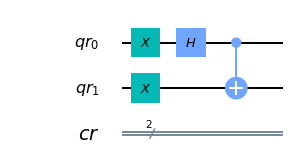

In [4]:
# this is charlies circuit, she will create entangled pair and send it to Alice and Bob
Charl_QC_ent = QuantumCircuit(qr, cr, name='Entanglement ckt')
Charl_QC_ent.x(qr[0])
Charl_QC_ent.x(qr[1])
Charl_QC_ent.h(qr[0])
Charl_QC_ent.cx(qr[0],qr[1])
#not to measure, we need an entangled state
#this will create an entangles state. (in the real world they use photons)
#qr_0 will go to Alice
#qr_1 will go to Bob
Charl_QC_ent.draw('mpl')

Alice and Bob will apply some measurements on the qubit. 
qr_0 will go to **Alice** and she will measure the qubits projection in the X basis, followed by the W basis and finally the  Z basis.
qr_1 will go to **Bob** and he will measure the qubits projection in W, Z and V basis.

As you can see both Alice and Bob apply the same X and W basis. I.e they are common and will be used to generate the keys.

In [5]:
## Alice's measurement circuits
#qr_0 will goto Alice
#can use any transformation but need two common

# measure the spin projection of Alice's qubit onto the a_1 direction (X basis)
#this used a H gate
#1
measureA_X = QuantumCircuit(qr, cr, name='measure_A_X')
measureA_X.h(qr[0])
measureA_X.measure(qr[0],cr[0])
#print(measureA_X) #plot the ckt

#2
# measure the spin projection of Alice's qubit onto the a_2 direction (W basis)
#this uses S,H and T gates
measureA_W = QuantumCircuit(qr, cr, name='measure_A_W')
measureA_W.s(qr[0])
measureA_W.h(qr[0])
measureA_W.t(qr[0])
measureA_W.h(qr[0])
measureA_W.measure(qr[0],cr[0])
#print(measureA_W) #print the ckt

#3
# measure the spin projection of Alice's qubit onto the a_3 direction (standard Z basis)
#uses no gates, just measure
measureA_Z = QuantumCircuit(qr, cr, name='measure_A_Z')
measureA_Z.measure(qr[0],cr[0])
#print(measureA_Z)


##Do the same on Bobs site qr_1 will goto Bobs site

#1
# measure the spin projection of Bob's qubit onto the b_1 direction (W basis)
#this uses S,H and T gates
measureB_W = QuantumCircuit(qr, cr, name='measureB1')
measureB_W.s(qr[1])
measureB_W.h(qr[1])
measureB_W.t(qr[1])
measureB_W.h(qr[1])
measureB_W.measure(qr[1],cr[1])
#print(measureB_W)

#2
# measure the spin projection of Bob's qubit onto the b_2 direction (standard Z basis)
#uses no gates, just measure
measureB_Z = QuantumCircuit(qr, cr, name='measureB2')
measureB_Z.measure(qr[1],cr[1])
#print(measureB_Z)

#3
# measure the spin projection of Bob's qubit onto the b_3 direction (V basis)
#uses S,H,tgd gates
measureB_V = QuantumCircuit(qr, cr, name='measureB3')
measureB_V.s(qr[1])
measureB_V.h(qr[1])
measureB_V.tdg(qr[1])
measureB_V.h(qr[1])
measureB_V.measure(qr[1],cr[1])
#print(measureB_V)

## Lists of measurement circuits
A_Measured = [measureA_X, measureA_W, measureA_W]
B_Measured = [measureB_W, measureB_Z, measureB_V]

The code above will generate circuits to project the qubits state in the V,W,X,Z basis as mentioned above.

Now we define how many entangled particles will we send inorder to generate the key. After that we will randomly choose these above mentioned measurements (these will be called alice and bob choices)

In [6]:
# Define the number of entangled particles, larger the better
Num_entangled_particles = 50

In [7]:
#randomly choose bweteen the which measurement to perform

A_Measure_Choice = [random.randint(1, 3) for i in range(Num_entangled_particles)] # string b of Alice
B_Measure_Choice = [random.randint(1, 3) for i in range(Num_entangled_particles)] # string b' of Bob

In [8]:
#create a list of circuits to be executed at once
circuits = []

#A_Measurere and B_Measure are lists which contain alice and Bobs choices

#randomly choose a circuit
for i in range(Num_entangled_particles):
    #first an entangled pair will be created at charls end and one particle will be sent to alices end and another at bobs end
    #thus inorder to measure them simultaniously we compbine the circuits and execute it in one go.
    
    #in the real world one of the qubit generated by charlie will be sent to alice who will create a superposition by randomly choosing the measurements.
    #Bob will do the same at his site.
    #both measure them. Since its an entangled state, there will be some similarities in the measurements
    
    circuitName = Charl_QC_ent + A_Measured[A_Measure_Choice[i]-1] + B_Measured[B_Measure_Choice[i]-1]

    #technically Alice and Bob will measure this indivually at their own site
    circuits.append(circuitName)

In [9]:
#shoot one shot in the simulator
#for error mitigation shoot 3 or 4 shots and choose the one which has the higher probability

result = execute(circuits, backend=backend, shots=1).result() #execute the whole circuit

In [10]:
#technically Alice and Bob will measure this at their own site and store the results in A and A', if done so, we wont need this re.compile routine
Find_Patterns = [
    re.compile('00$'), # search for the '00' output (Alice obtained -1 and Bob obtained -1)
    re.compile('01$'), # search for the '01' output
    re.compile('10$'), # search for the '10' output (Alice obtained -1 and Bob obtained 1)
    re.compile('11$')  # search for the '11' output
]
#this basically searches digits XY in the given list

In [11]:
A_Res = [] # Alice's results (string a)
B_Res = [] # Bob's results (string a')

#search through all results to find the (Alice,bob): 00,01,10 and 11 digits. These correspond to (alice,bob) -1-1, 1-1,-11, 11; respectively 
for i in range(Num_entangled_particles):

    temp_res = list(result.get_counts(circuits[i]).keys())[0] # extract the key from the dict and transform it to str; execution result of the i-th circuit
    if Find_Patterns[0].search(temp_res): # check if the key is '00' (if the measurement results are -1,-1)
        A_Res.append(-1) # Alice got the result -1 
        B_Res.append(-1) # Bob got the result -1
        
    if Find_Patterns[1].search(temp_res):
        A_Res.append(1)
        B_Res.append(-1)
        
    if Find_Patterns[2].search(temp_res): # check if the key is '10' (if the measurement results are -1,1)
        A_Res.append(-1) # Alice got the result -1 
        B_Res.append(1) # Bob got the result 1
        
    if Find_Patterns[3].search(temp_res): 
        A_Res.append(1)
        B_Res.append(1)


In [12]:
A_Key = [] # Alice's key string k
B_Key = [] # Bob's key string k'
#inorder to generate the key, check the common rotations that both the qubits did
# comparing the stings with measurement choices
for i in range(Num_entangled_particles):
    # if Alice and Bob have measured the spin projections onto the a_2/b_1 or a_3/b_2 directions
    #check where Alice and Bob applied the same projections, at that position, both will have equal and opposite qubit measurements
    
    if (A_Measure_Choice[i] == 2 and B_Measure_Choice[i] == 1) or (A_Measure_Choice[i] == 3 and B_Measure_Choice[i] == 2):
        A_Key.append(A_Res[i]) # record the i-th result obtained by Alice as the bit of the secret key k
        B_Key.append(- B_Res[i]) # record the multiplied by -1 i-th result obtained Bob as the bit of the secret key k'

In [13]:
#convert the -1 to 0 and keep the 1s
#inorder to generate a binary key, convert the negative 1s to 0s
#this is not required 
str_Ak =''
str_Bk =''
for i in A_Key:
    if i == -1:
        str_Ak+='0'
    else:
        str_Ak+='1'
        
for i in B_Key:
    if i == -1:
        str_Bk+='0'
    else:
        str_Bk+='1'
print(str_Ak)
print(str_Bk)
if str_Ak == str_Bk:
    print('its a match')

11011101
11011101
its a match


Note: One can use this key to encrypt a message and send it. It should be noted that length of the key should be equal to or longer than the length of the message.

Note: In the case where one wants to simulate a quantum channel/network, one can use repeaters to send the qubits to Alice and Bob, as done in the BB84 project notebook.